With this model, we look for the position of hospitals and clinics to minimize the distance between the patient, hospitals and clinics. 
This can help us, for example, to decise where to build an hospital in the future.

* Sets\
$\text {I: The set of demand points i, } \forall i = (1,2,...,n)$
$\text {K: The set of candidate locations for a level-1 PCF (e.g., clinics) k, } \forall i = (1,2,...,n)$
$\text {J: The set of candidate locations for a level-2 PCF (e.g., hospitals) j, } \forall i = (1,2,...,n)$
* Parameters\
$d_{ik} \text {: The travel distance (or time) between demand point i ∈ I and a level-1 PCF in candidate location k ∈ K .} \forall i \in N, i \not =\{s\}$\
$d_{ik} \text {: The travel distance (or time) between a level-1 PCF in candidate location k ∈ K and a level-2 PCF in candidate location j ∈ J .} \forall i \in N, i \not =\{s\}$\
$w_i \text {: The population size at demand poin i ∈ I }$\
$C_{k}^1 \text {: The capacity of the clinic k}$\
$C_{j}^2 \text {: The capacity of the hospital j}$\
$p \text {: The number of clinics to be established}$\
$q \text {: The number of hospitals to be established}$\
$\theta_k \text {: The proportion of patients in the clinic k who have to go to an hospital}$\

* Variables\
$
x_{k}^1=
\begin{cases}
1 \text{ if clinic } k \text{ is activated},\\
0 \text{ otherwise}
\end{cases}
$\
$
x_{j}^2=
\begin{cases}
1 \text{ if hospital } j \text{ is activated},\\
0 \text{ otherwise}
\end{cases}
$\
$u_{ik} \text {: The flow of patients between demand point i and the clinic k (e.g. flow of arc going from node i to node k)} \forall i,j  \in N$\
$v_{kj} \text {: The flow of patients from the clinic k who have to ho to the hospital j (e.g. flow of arc going from node k to node j)} \forall i,j  \in N$

* Objective function
$$
% peut etre mettre des indices genre de 1 à n
\min  \sum_{i \in I}^n \sum_{k \in K} d_{ik}* u_{ik} + \sum_{k \in K}^n \sum_{j \in J} d_{kj}* v_{kj}
$$

* Constraints\
* type de contraintes ?
$$
\sum_{k \in K} u_{ik} = w_i \text{  } \forall i \in I
$$
* Flow balance constraints.
$$
\sum_{j \in J} v_{kj} = \theta_k  \sum_{i \in I} u_{ik} \text{  } \forall k \in K
$$
* Activation constraints
$$
0 \leq x_{ij} \leq u_{ij}*y_{ij} \forall i, j \in N
$$

In [810]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gb

%matplotlib inline

In [811]:
#Drawing function

def DrawInitG(G, figure_size, withedges=False):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]
    
    
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6,\
                           node_shape='o', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'dist').get('dist') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, figure_size, x):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]

    # fontsize=8,
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6, \
                           node_shape='o', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    
    nx.draw_networkx_edges(G,pos=pos, edgelist = x, alpha=1.0)
    
        
    
    plt.axis('off')
    plt.show()

In [812]:
# Setting the network values (1)

number_of_clinic = 10
number_of_hospitals = 10
number_of_demand_points = 5

K = range(0, number_of_clinic)
J = range(number_of_clinic, number_of_clinic + number_of_hospitals)
I = range(number_of_clinic + number_of_hospitals, number_of_clinic + number_of_hospitals + number_of_demand_points)

area_size = 10

# Number of candidate clinic's to be established
p = 5
# Number of candidate hospital's to be established
q = 5

# Portion of patient in a clinic k referred to an hospital 
theta = {k:round(random.random(),2) for k in K}

In [813]:
theta

{0: 0.22,
 1: 0.85,
 2: 0.0,
 3: 0.92,
 4: 0.26,
 5: 0.07,
 6: 0.29,
 7: 0.83,
 8: 0.58,
 9: 0.03}

In [814]:
#Creating a random network and removing all edges

G = nx.complete_graph(number_of_clinic + number_of_hospitals + number_of_demand_points)
G = nx.create_empty_copy(G)
pos = nx.random_layout(G)

In [815]:
#Setting the network values (2)
# on peut aussi dire que tous les hopitaux et cliniques ont la même capacité d'accueil
# C1 = {k:random.randint(20,100) for k in range(len(G)) if k >= 0 and k < number_of_clinic} # a clinic can accommodate between 20 and 100 people

# C2 = {j:random.randint(100,300) for j in range(len(G)) if j >= number_of_clinic and j < number_of_clinic + number_of_hospitals}# an hospital can accommodate between 100 and 300 people

# C = {}
# for i in range(len(G)):
#     if i >= 0 and i < number_of_clinic:
#         C[i] = random.randint(50,200)
#         # a clinic can accommodate between 20 and 100 people
#     elif i >= number_of_clinic and i < number_of_clinic + number_of_hospitals:
#         C[i] = random.randint(200,400)
#         # an hospital can accommodate between 100 and 300 people
#     else:
#         C[i] = random.randint(0,50)
#         # population in node i

C = {}
for i in range(len(G)):
    if i >= 0 and i < number_of_clinic:
        if i % 2 == 0:
            C[i] = 50
        else :
            C[i] = 100
        # a clinic can accommodate between 20 and 100 people
    elif i >= number_of_clinic and i < number_of_clinic + number_of_hospitals:
        if i % 2 == 0:
            C[i] = 200
        else :
            C[i] = 400
        # an hospital can accommodate between 100 and 300 people
    else:
        C[i] = random.randint(0,50)
        # population in node i

In [816]:
#Changing the size of the network

for i in range(len(pos.values())) :
    pos[i] = pos[i]*area_size

In [817]:
#Assinging the pos values to the x and y attribute of each node

for i in range(len(G)):
    G.nodes[i]["x"] = pos[i][0]
    G.nodes[i]["y"] = pos[i][1]

In [818]:
G.nodes(data=True)

NodeDataView({0: {'x': 7.544596, 'y': 3.130778}, 1: {'x': 9.436456, 'y': 1.313803}, 2: {'x': 1.187547, 'y': 3.9685485}, 3: {'x': 5.666172, 'y': 3.590689}, 4: {'x': 5.8614864, 'y': 9.765576}, 5: {'x': 9.254028, 'y': 9.3396435}, 6: {'x': 4.4666944, 'y': 5.461565}, 7: {'x': 1.6103584, 'y': 7.36733}, 8: {'x': 2.9595675, 'y': 5.863471}, 9: {'x': 7.6332655, 'y': 1.7914698}, 10: {'x': 4.9897604, 'y': 0.6766976}, 11: {'x': 7.306732, 'y': 2.880978}, 12: {'x': 9.665514, 'y': 9.10261}, 13: {'x': 6.006053, 'y': 8.355342}, 14: {'x': 7.209213, 'y': 7.4909263}, 15: {'x': 4.8904324, 'y': 6.4511943}, 16: {'x': 7.7358065, 'y': 1.2740076}, 17: {'x': 2.1882937, 'y': 1.8887522}, 18: {'x': 1.7577659, 'y': 8.689312}, 19: {'x': 1.9626048, 'y': 0.3358335}, 20: {'x': 0.3671783, 'y': 5.075143}, 21: {'x': 9.961489, 'y': 5.2313256}, 22: {'x': 1.5242351, 'y': 2.609212}, 23: {'x': 3.7501538, 'y': 6.1537886}, 24: {'x': 5.5994053, 'y': 4.8472147}})

In [819]:
#Assining what type of location a node is and its color
#For recipint points, we give the variable w which is the demand size at organ recipient point


for i in range(len(G)):
    if i >= 0 and i < number_of_clinic:
        G.nodes[i]['color'] = "blue"
        G.nodes[i]['location_type'] = "clinic"
        G.nodes[i]['capacity'] = C[i]
    elif i >= number_of_clinic and i < number_of_clinic + number_of_hospitals:
        G.nodes[i]['color'] = "red"
        G.nodes[i]['location_type'] = "hospital"
        G.nodes[i]['capacity'] = C[i]
    else:
        G.nodes[i]['color'] = "green"
        G.nodes[i]['location_type'] = "demand point"
        G.nodes[i]['capacity'] = C[i]

In [820]:
G.nodes(data=True)

NodeDataView({0: {'x': 7.544596, 'y': 3.130778, 'color': 'blue', 'location_type': 'clinic', 'capacity': 50}, 1: {'x': 9.436456, 'y': 1.313803, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 2: {'x': 1.187547, 'y': 3.9685485, 'color': 'blue', 'location_type': 'clinic', 'capacity': 50}, 3: {'x': 5.666172, 'y': 3.590689, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 4: {'x': 5.8614864, 'y': 9.765576, 'color': 'blue', 'location_type': 'clinic', 'capacity': 50}, 5: {'x': 9.254028, 'y': 9.3396435, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 6: {'x': 4.4666944, 'y': 5.461565, 'color': 'blue', 'location_type': 'clinic', 'capacity': 50}, 7: {'x': 1.6103584, 'y': 7.36733, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 8: {'x': 2.9595675, 'y': 5.863471, 'color': 'blue', 'location_type': 'clinic', 'capacity': 50}, 9: {'x': 7.6332655, 'y': 1.7914698, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 10: {'x': 4.9897604, 'y'

In [821]:
#Creating the edges that are only useful, e.g the ones between demand point and clinic and clinic and hospital location
#Adding the cost (e.g distance) and naming it a or t accordingly to the pdf.

index_of_clinic = list(K)
index_of_hospitals = list(J)
index_of_demand_points = list(I)


for source in index_of_demand_points:
    for target in index_of_clinic:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,a=distance, dist=distance)
        
for source in index_of_clinic:
    for target in index_of_hospitals:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,t=distance, dist=distance)

In [822]:
print(index_of_clinic)
print(index_of_hospitals)
print(index_of_demand_points)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24]


In [823]:
G.edges(data=True)

EdgeDataView([(0, 20, {'a': 7.436119959577324, 'dist': 7.436119959577324}), (0, 21, {'a': 3.2021351491080576, 'dist': 3.2021351491080576}), (0, 22, {'a': 6.042911316536211, 'dist': 6.042911316536211}), (0, 23, {'a': 4.85143130212712, 'dist': 4.85143130212712}), (0, 24, {'a': 2.59420938801088, 'dist': 2.59420938801088}), (0, 10, {'t': 3.5425552144812706, 'dist': 3.5425552144812706}), (0, 11, {'t': 0.3449337823904691, 'dist': 0.3449337823904691}), (0, 12, {'t': 6.337275568968042, 'dist': 6.337275568968042}), (0, 13, {'t': 5.446391470442178, 'dist': 5.446391470442178}), (0, 14, {'t': 4.373028283204808, 'dist': 4.373028283204808}), (0, 15, {'t': 4.250852796485984, 'dist': 4.250852796485984}), (0, 16, {'t': 1.866589969527397, 'dist': 1.866589969527397}), (0, 17, {'t': 5.4984181482051575, 'dist': 5.4984181482051575}), (0, 18, {'t': 8.024007908445263, 'dist': 8.024007908445263}), (0, 19, {'t': 6.242622894677251, 'dist': 6.242622894677251}), (1, 20, {'a': 9.81832353378511, 'dist': 9.8183235337

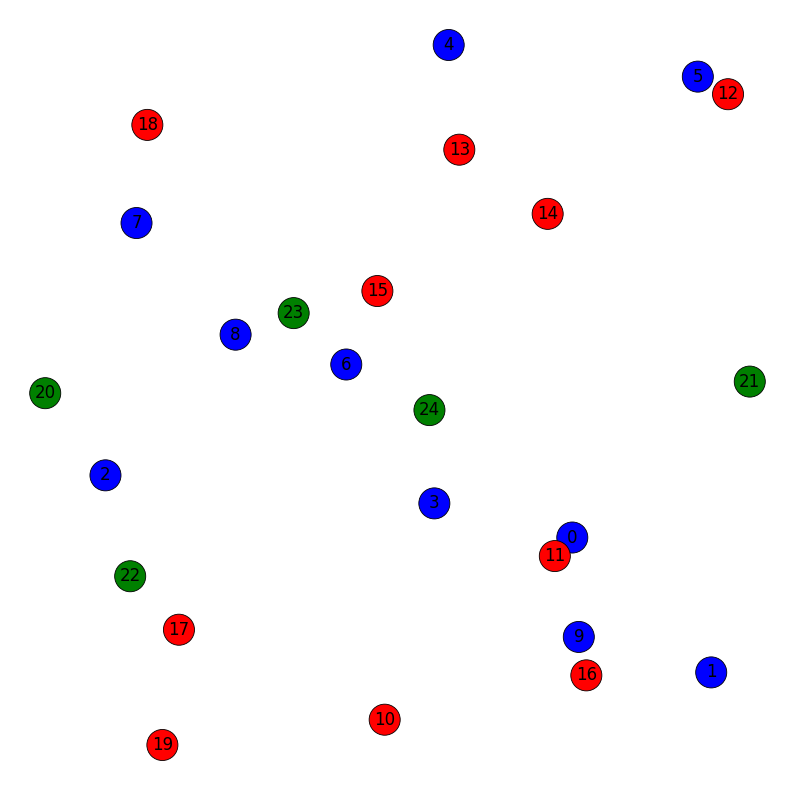

In [824]:
DrawInitG(G,(10,10), withedges=False)

## Optimizing the model

In [825]:
#Creating the model
pcf = gb.Model('Primary care facility')

In [826]:
# je crois que c'est bon maintenant
# Variable decision x1, x1[k] = 1 if clinic k is established
x1 = pcf.addVars(index_of_clinic,vtype=gb.GRB.BINARY, name='x1')
# Variable decision x2, x2[j] = 1 if hospital j is established
x2 = pcf.addVars(index_of_hospitals,vtype=gb.GRB.BINARY, name='x2')
# Variable decision u, u[i][k] = number of patient who go to node i to clinic k
u = pcf.addVars([(i,k) for i in index_of_demand_points for k in index_of_clinic],
                lb = 0, 
                obj=[G.edges[(i,k)]['dist'] for i in index_of_demand_points for k in index_of_clinic], 
                vtype=gb.GRB.INTEGER, name='u')
# Variable decision v, v[k][j] = number of patient who go to clinic k to hospital j
v = pcf.addVars([(k,j) for k in index_of_clinic for j in index_of_hospitals],
                lb = 0, 
                obj=[G[k][j]['dist'] for k in index_of_clinic for j in index_of_hospitals], 
                vtype=gb.GRB.INTEGER, name='v')
pcf.update()
pcf.write('pcf.lp')


In [827]:
0.78 * 7

5.46

In [828]:
round(0.78 * 7)

5

In [829]:
theta[0]*u.sum('*',0)

<gurobi.LinExpr: 0.22 u[20,0] + 0.22 u[21,0] + 0.22 u[22,0] + 0.22 u[23,0] + 0.22 u[24,0]>

### Constraints

In [830]:
# verifier les range
pcf.addConstrs((u.sum(i, '*') == C[i] for i in index_of_demand_points), name='29')
pcf.addConstrs((v.sum(k, '*') >= theta[k]*u.sum('*',k) for k in index_of_clinic), name='30')
# the constraint 30 is the main problem to unfeasible

pcf.addConstrs((u.sum('*', k) <= C[k]*x1[k] for k in index_of_clinic), name='31')
pcf.addConstrs((v.sum('*', j) <= C[j]*x2[j] for j in index_of_hospitals), name='32')

pcf.addConstr(x1.sum('*') == p , name='33')
pcf.addConstr(x2.sum('*') == q , name='34')

pcf.update()
pcf.write('pcf.lp')

# Domain constraints
# pcf.addConstrs((u[i,k] >= 0 for i in range(number_of_clinic + number_of_hospitals, number_of_clinic + number_of_hospitals + number_of_demand_points) for k in range(number_of_clinic, number_of_clinic + number_of_hospitals)), name='35')
# pcf.addConstrs((v[k,j] >= 0 for k in range(number_of_clinic, number_of_clinic + number_of_hospitals) for j in range(0, number_of_clinic)), name='36')
# useless before be can define it 


In [831]:
totalcapacityclinic = 0
for k in index_of_clinic:
    totalcapacityclinic = totalcapacityclinic + C[k]
totalcapacityhospital = 0
for k in index_of_hospitals:
    totalcapacityhospital = totalcapacityhospital + C[k]
totaldemand = 0
for k in index_of_demand_points:
    totaldemand = totaldemand + C[k]
print(totalcapacityclinic)
print(totalcapacityhospital)
print(totaldemand)

750
3000
158


In [832]:
pcf.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 37 rows, 170 columns and 385 nonzeros
Model fingerprint: 0x0a7cb15e
Variable types: 0 continuous, 170 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 4e+02]
  Objective range  [3e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 5e+01]
Found heuristic solution: objective 947.8656632
Presolve removed 1 rows and 10 columns
Presolve time: 0.00s
Presolved: 36 rows, 160 columns, 365 nonzeros
Variable types: 0 continuous, 160 integer (20 binary)
Found heuristic solution: objective 938.5228644

Root relaxation: objective 3.004194e+02, 21 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   

In [833]:
print('Obj: %g' % pcf.objVal)


Obj: 301.942


In [834]:
print(pcf.getVars())

[<gurobi.Var x1[0] (value 1.0)>, <gurobi.Var x1[1] (value -0.0)>, <gurobi.Var x1[2] (value 1.0)>, <gurobi.Var x1[3] (value 1.0)>, <gurobi.Var x1[4] (value 0.0)>, <gurobi.Var x1[5] (value -0.0)>, <gurobi.Var x1[6] (value 1.0)>, <gurobi.Var x1[7] (value 0.0)>, <gurobi.Var x1[8] (value 1.0)>, <gurobi.Var x1[9] (value -0.0)>, <gurobi.Var x2[10] (value 0.0)>, <gurobi.Var x2[11] (value 1.0)>, <gurobi.Var x2[12] (value 1.0)>, <gurobi.Var x2[13] (value 0.0)>, <gurobi.Var x2[14] (value 0.0)>, <gurobi.Var x2[15] (value 1.0)>, <gurobi.Var x2[16] (value 1.0)>, <gurobi.Var x2[17] (value 0.0)>, <gurobi.Var x2[18] (value 1.0)>, <gurobi.Var x2[19] (value 0.0)>, <gurobi.Var u[20,0] (value 0.0)>, <gurobi.Var u[20,1] (value 0.0)>, <gurobi.Var u[20,2] (value 39.0)>, <gurobi.Var u[20,3] (value 0.0)>, <gurobi.Var u[20,4] (value 0.0)>, <gurobi.Var u[20,5] (value 0.0)>, <gurobi.Var u[20,6] (value 0.0)>, <gurobi.Var u[20,7] (value 0.0)>, <gurobi.Var u[20,8] (value 0.0)>, <gurobi.Var u[20,9] (value 0.0)>, <guro

In [835]:

print ()

for y in pcf.getVars():
    if y.x > 1E-3:
        print ('%s=%g' % (y.varName, y.x), end = ' ')


x1[0]=1 x1[2]=1 x1[3]=1 x1[6]=1 x1[8]=1 x2[11]=1 x2[12]=1 x2[15]=1 x2[16]=1 x2[18]=1 u[20,2]=39 u[21,0]=27 u[22,2]=9 u[23,6]=5 u[23,8]=31 u[24,0]=2 u[24,6]=45 v[0,11]=7 v[6,15]=15 v[8,15]=18 

In [836]:
u

{(20, 0): <gurobi.Var u[20,0] (value 0.0)>,
 (20, 1): <gurobi.Var u[20,1] (value 0.0)>,
 (20, 2): <gurobi.Var u[20,2] (value 39.0)>,
 (20, 3): <gurobi.Var u[20,3] (value 0.0)>,
 (20, 4): <gurobi.Var u[20,4] (value 0.0)>,
 (20, 5): <gurobi.Var u[20,5] (value 0.0)>,
 (20, 6): <gurobi.Var u[20,6] (value 0.0)>,
 (20, 7): <gurobi.Var u[20,7] (value 0.0)>,
 (20, 8): <gurobi.Var u[20,8] (value 0.0)>,
 (20, 9): <gurobi.Var u[20,9] (value 0.0)>,
 (21, 0): <gurobi.Var u[21,0] (value 27.0)>,
 (21, 1): <gurobi.Var u[21,1] (value -0.0)>,
 (21, 2): <gurobi.Var u[21,2] (value 0.0)>,
 (21, 3): <gurobi.Var u[21,3] (value 0.0)>,
 (21, 4): <gurobi.Var u[21,4] (value 0.0)>,
 (21, 5): <gurobi.Var u[21,5] (value -0.0)>,
 (21, 6): <gurobi.Var u[21,6] (value 0.0)>,
 (21, 7): <gurobi.Var u[21,7] (value 0.0)>,
 (21, 8): <gurobi.Var u[21,8] (value 0.0)>,
 (21, 9): <gurobi.Var u[21,9] (value -0.0)>,
 (22, 0): <gurobi.Var u[22,0] (value 0.0)>,
 (22, 1): <gurobi.Var u[22,1] (value 0.0)>,
 (22, 2): <gurobi.Var u[22,

In [837]:
v

{(0, 10): <gurobi.Var v[0,10] (value 0.0)>,
 (0, 11): <gurobi.Var v[0,11] (value 7.0)>,
 (0, 12): <gurobi.Var v[0,12] (value 0.0)>,
 (0, 13): <gurobi.Var v[0,13] (value 0.0)>,
 (0, 14): <gurobi.Var v[0,14] (value 0.0)>,
 (0, 15): <gurobi.Var v[0,15] (value 0.0)>,
 (0, 16): <gurobi.Var v[0,16] (value -0.0)>,
 (0, 17): <gurobi.Var v[0,17] (value 0.0)>,
 (0, 18): <gurobi.Var v[0,18] (value 0.0)>,
 (0, 19): <gurobi.Var v[0,19] (value 0.0)>,
 (1, 10): <gurobi.Var v[1,10] (value 0.0)>,
 (1, 11): <gurobi.Var v[1,11] (value 0.0)>,
 (1, 12): <gurobi.Var v[1,12] (value 0.0)>,
 (1, 13): <gurobi.Var v[1,13] (value 0.0)>,
 (1, 14): <gurobi.Var v[1,14] (value 0.0)>,
 (1, 15): <gurobi.Var v[1,15] (value 0.0)>,
 (1, 16): <gurobi.Var v[1,16] (value -0.0)>,
 (1, 17): <gurobi.Var v[1,17] (value 0.0)>,
 (1, 18): <gurobi.Var v[1,18] (value 0.0)>,
 (1, 19): <gurobi.Var v[1,19] (value 0.0)>,
 (2, 10): <gurobi.Var v[2,10] (value -0.0)>,
 (2, 11): <gurobi.Var v[2,11] (value -0.0)>,
 (2, 12): <gurobi.Var v[2,12

In [838]:
#Creating xfinal, the dict of all active edges

xfinal = dict(u)
xfinal.update(v)

#Removing the key from the dict if the value is 0, e.G the edge isn't active
for xtuple in list(xfinal) :
    # print(xfinal[xtuple])
    # print(xfinal[xtuple].x)
    if xfinal[xtuple].x == 0 :
        xfinal.pop(xtuple, None)

In [839]:
xfinal

{(20, 2): <gurobi.Var u[20,2] (value 39.0)>,
 (21, 0): <gurobi.Var u[21,0] (value 27.0)>,
 (22, 2): <gurobi.Var u[22,2] (value 9.0)>,
 (23, 6): <gurobi.Var u[23,6] (value 5.0)>,
 (23, 8): <gurobi.Var u[23,8] (value 31.0)>,
 (24, 0): <gurobi.Var u[24,0] (value 2.0)>,
 (24, 6): <gurobi.Var u[24,6] (value 45.0)>,
 (0, 11): <gurobi.Var v[0,11] (value 7.0)>,
 (6, 15): <gurobi.Var v[6,15] (value 15.0)>,
 (8, 15): <gurobi.Var v[8,15] (value 18.0)>}

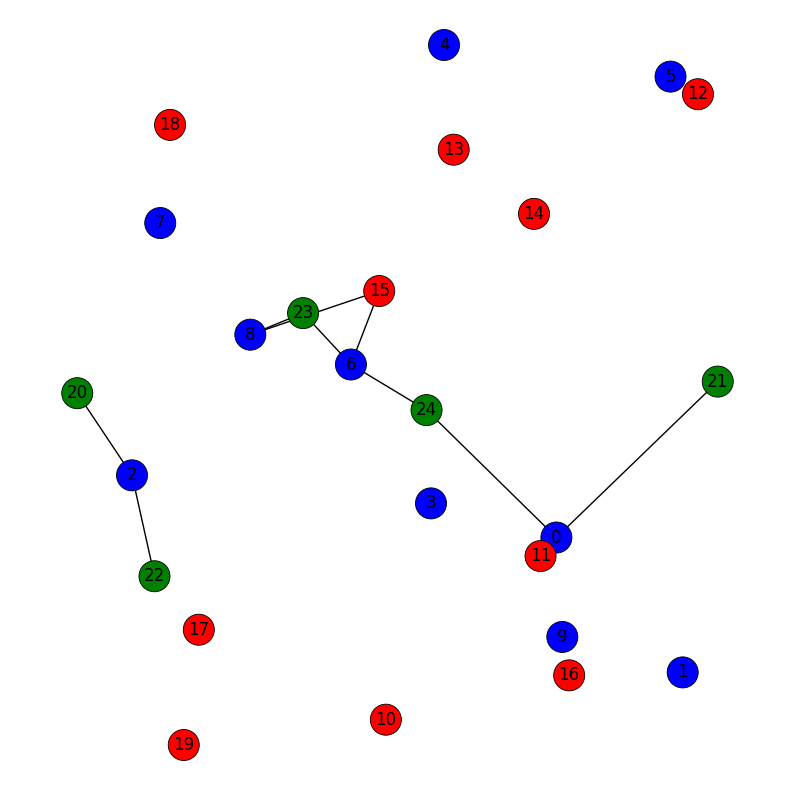

In [840]:
DrawSol(G, (10,10), xfinal)